In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from plots import *
from kls import *
from torch.distributions.normal import Normal
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
from torch.distributions.beta import Beta
from torch.distributions.uniform import Uniform
from torch.distributions.relaxed_categorical import RelaxedOneHotCategorical as rcat
from torch import logsumexp
import sys
import time
import datetime
import math

In [2]:
Xs = torch.from_numpy(np.load('triangles/obs-60.npy')).float()
Mus = torch.from_numpy(np.load('triangles/mus-60.npy')).float()

B, N, D = Xs.shape

## Model Parameters
NUM_SAMPLES = 10
NUM_HIDDEN = 32
NUM_LATENTS = 2
NUM_OBS = D
NUM_EPOCHS = 100
LEARNING_RATE = 1e-4
CUDA = False
PATH = 'circles'

In [3]:
class Encoder(nn.Module):
    def __init__(self, num_obs= NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_h = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh())
        self.enc_mu = nn.Sequential(
            nn.Linear(num_hidden, int(0.5*num_hidden)),
            nn.Tanh(),
            nn.Linear(int(0.5*num_hidden), num_latents))
        self.enc_log_sigma = nn.Sequential(
            nn.Linear(num_hidden, int(0.5*num_hidden)),
            nn.Tanh(),
            nn.Linear(int(0.5*num_hidden), num_latents))

    def forward(self, obs, num_samples):
        h = self.enc_h(obs) # (B, H)
        mu = self.enc_mu(h) # (B, 2)
        sigma = torch.exp(self.enc_log_sigma(h)) # (B, 2)
        q_u = Normal(mu, sigma)
        u = q_u.sample((num_samples,)) # (S, B, 2)
        log_q_u = q_u.log_prob(u).sum(-1)
        return u, log_q_u
    
    
class Decoder(nn.Module):
    def __init__(self, num_obs=D,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()

        self.x_sigma = 0.01 * torch.ones((N, num_obs))
        self.dec_mu = nn.Sequential(
            nn.Linear(num_latents, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_obs))

    def forward(self, u, obs, num_samples):
        mu = self.dec_mu(u) # (S, B, K) -> (S, B, O)
        p_x = Normal(mu, self.x_sigma.repeat(num_samples, 1, 1)) # (S, B, O)
        log_p_x = p_x.log_prob(obs).sum(-1) # (S, B)
        return mu, log_p_x

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 1e-2)     
        
def initialize():
    enc = Encoder()
    dec = Decoder()
#     enc.apply(weights_init)
    opt1 =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99)) 
    opt2 = torch.optim.Adam(list(dec.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))
    return enc, dec, opt1, opt2
enc, dec, opt1, opt2 = initialize()

In [5]:
def oneshot(x, mean, N, D, num_samples):
    data = x - mean

    u, log_q = enc(data, num_samples)
    mu, log_p_x = dec(u, data, num_samples)
    pr_u = Normal(torch.zeros(N, NUM_LATENTS), torch.ones(N, NUM_LATENTS))
    log_pr_u = pr_u.log_prob(u).sum(-1)
    log_weights = (log_pr_u + log_p_x - log_q)
    weights = torch.exp(log_weights - logsumexp(log_weights, 0)).detach()
    eubo = torch.mul(weights, log_weights).sum(0).mean()
    elbo = log_weights.mean(0).mean()

    return eubo, elbo, mu, u

In [6]:
ELBOs = []
EUBOs = []
time_start = time.time()

for epoch in range(NUM_EPOCHS):
    for b in range(B):
        X = Xs[b]
        mean = Mus[b]
        indices = torch.randperm(N)
        X_shuffle = X[indices]
        opt1.zero_grad()
        eubo, elbo, mu, u = oneshot(X_shuffle, mean, N, D, NUM_SAMPLES)
        eubo.backward()
        opt1.step()
        opt2.zero_grad()
        eubo, elbo, mu, u = oneshot(X_shuffle, mean, N, D, NUM_SAMPLES)
        (-elbo).backward()
        opt2.step()
    
        ELBOs.append(elbo.item())
        EUBOs.append(eubo.item())
    

    time_end = time.time()  
    print('epoch=%d, EUBO=%.3f, ELBO=%.3f (%ds)' % (epoch, eubo, elbo, time_end - time_start))
    time_start = time.time()


epoch=0, EUBO=0.305, ELBO=-4.821 (18s)
epoch=1, EUBO=-0.256, ELBO=-0.495 (18s)
epoch=2, EUBO=-0.195, ELBO=-0.446 (17s)
epoch=3, EUBO=-0.168, ELBO=-0.396 (17s)
epoch=4, EUBO=-0.040, ELBO=-0.319 (18s)
epoch=5, EUBO=-0.002, ELBO=-0.292 (17s)
epoch=6, EUBO=0.167, ELBO=-0.123 (18s)
epoch=7, EUBO=0.279, ELBO=-0.117 (18s)


KeyboardInterrupt: 

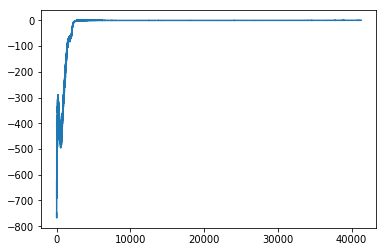

In [8]:
plt.plot(EUBOs)

In [7]:
torch.save(enc.state_dict(), 'VAE/enc-triangle')
torch.save(dec.state_dict(), 'VAE/dec-triangle')

In [12]:
P = 2
eubo, elbo, mu, u = oneshot(Xs[P], Mus[P], N, D, NUM_SAMPLES)

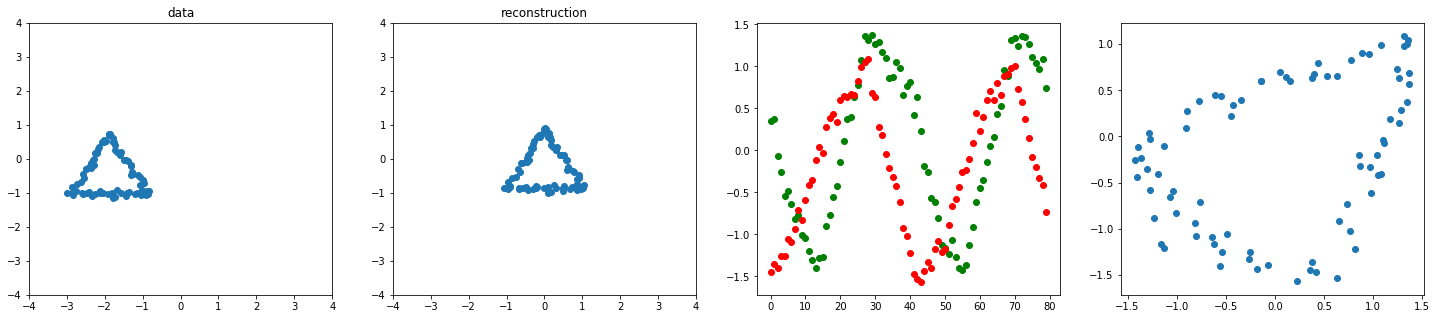

In [19]:
T = 80
fig = plt.figure(figsize=(25,5))
ax1 = fig.add_subplot(1,4,1)
ax2 = fig.add_subplot(1,4,2)   
ax3 = fig.add_subplot(1,4,3)
ax4 = fig.add_subplot(1,4,4)

ax1.scatter(Xs[P,:T, 0].data.numpy(), Xs[P, :T, 1].data.numpy())
ax1.set_xlim([-4,4])
ax1.set_ylim([-4,4])
ax1.set_title('data')

ax2.scatter(mu[0,:T, 0].data.numpy(), mu[0, :T, 1].data.numpy())
ax2.set_title('reconstruction')
ax2.set_xlim([-4,4])
ax2.set_ylim([-4,4])

uu = u.mean(0)
ax3.plot(uu[:T, 0].data.numpy(), 'go')
ax3.plot(uu[:T, 1].data.numpy(), 'ro')

ax4.scatter(uu[:T, 0].data.numpy(), uu[:T, 1].data.numpy())


In [17]:
mu.shape

torch.Size([10, 210, 2])